In [39]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option("display.precision", 8)

In [40]:
df = pd.read_csv("./data/titanic.csv")

In [41]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [42]:
def prepare(df):
    df.Age.fillna(0,inplace=True)
    df.Age = df.Age.astype(float)
    return df

In [43]:
df = prepare(df)

<AxesSubplot:>

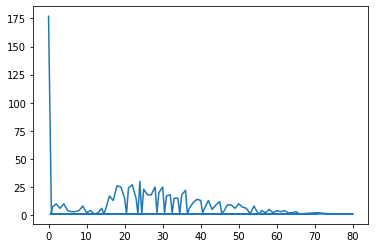

In [44]:
df.Age.sort_values().value_counts(sort=False).plot()

## calcul de la CDF

In [45]:
def compute_stat(df):
    # compte combien de fois chaque valeur d'age est présente
    freq = df.Age.value_counts()

    # Probality Distribution Function : la fréquence sur la somme totale
    pdf = freq / sum(freq)

    # Cumulative Distribution Function : la somme cumulée de chaque PDF (triées !)
    cdf = pdf.sort_index().cumsum()

    return freq, pdf, cdf

In [46]:
freq, pdf, cdf = compute_stat(df)
cdf.head(10)

0.00    0.19865320
0.42    0.19977553
0.67    0.20089787
0.75    0.20314254
0.83    0.20538721
0.92    0.20650954
1.00    0.21436588
2.00    0.22558923
3.00    0.23232323
4.00    0.24354658
Name: Age, dtype: float64

<AxesSubplot:>

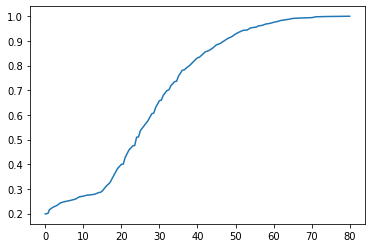

In [184]:
cdf.plot()

## build the X and y

In [262]:
cols_to_drop = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Cabin', 'Sex', 'SibSp', 'Parch','Ticket', 'Fare', 'Embarked']
def build_sortedtable(df, cdf):
    # add a column Agecdf to the dataframe
    joined = df.join(pd.DataFrame(data=cdf), on='Age', rsuffix='cdf')

    # sort values by Age
    sorted_byage = joined.sort_values('Age')
    
    # use the index as a new column 'offset'
    sorted_table = sorted_byage.reset_index().rename(columns={'index': 'offset'})

    # project Age as X and Agecdf as y 
    return sorted_table.drop(cols_to_drop, axis=1)

In [263]:
sorted_table = build_sortedtable(df, cdf)

In [270]:
sorted_table.sample(10).sort_index() # X is the column Age, y is the cdf values

,offset,Age,Agecdf
23,126,0.0,0.19865320
162,826,0.0,0.19865320
190,381,1.0,0.21436588
217,58,5.0,0.24803591
280,532,17.0,0.32547699
394,323,22.0,0.45791246
481,312,26.0,0.55667789
597,18,31.0,0.67901235
669,737,35.0,0.75645342
804,771,48.0,0.91021324


#### scaling back the cdf to find the i element : sorted_table [[ CDF x num elements - 1 ]]

In [283]:
# the CDF x num elements - 1 == i-st element
print( 0.19865320 * sorted_table.Age.count() - 1 )
sorted_table[sorted_table.Age == 0].iloc[-1]

176.0000012


offset    457.0000000
Age         0.0000000
Agecdf      0.1986532
Name: 176, dtype: float64

## fit(cdf), predic(cdf), and scale the result

In [310]:
from sklearn import datasets, linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(sorted_table.Age[:,None], sorted_table.Agecdf)

LinearRegression()

In [311]:
preds = pd.Series(name='preds',data=regr.predict(sorted_table.Age[:,None]))

In [312]:
all = pd.concat([sorted_table, preds], axis=1)

In [313]:
all.head()

,offset,Age,Agecdf,preds
0,667,0.0,0.1986532,0.17909954
1,128,0.0,0.1986532,0.17909954
2,533,0.0,0.1986532,0.17909954
3,284,0.0,0.1986532,0.17909954
4,538,0.0,0.1986532,0.17909954


In [329]:
all['guessed_i'] = pd.Series(all.preds * all.Age.count() - 1).round()
all['true_i'] = all.reset_index()['index']

In [330]:
all.sample(15)

,offset,Age,Agecdf,preds,guessed_i,guessed_index,true_i
658,20,35.0,0.75645342,0.69041020,614.0,614.0,658
718,835,39.0,0.81705948,0.74884571,666.0,666.0,718
669,737,35.0,0.75645342,0.69041020,614.0,614.0,669
78,158,0.0,0.19865320,0.17909954,159.0,159.0,78
863,232,59.0,0.97081930,1.04102323,927.0,927.0,863
37,768,0.0,0.19865320,0.17909954,159.0,159.0,37
335,143,19.0,0.38271605,0.45666819,406.0,406.0,335
338,372,19.0,0.38271605,0.45666819,406.0,406.0,338
414,658,23.0,0.47474747,0.51510369,458.0,458.0,414
266,156,16.0,0.31088664,0.41284156,367.0,367.0,266


<AxesSubplot:xlabel='Age'>

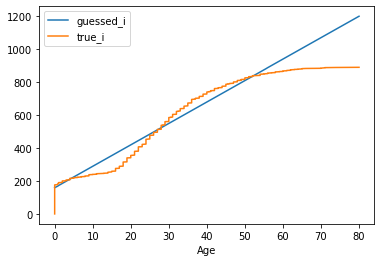

In [332]:
all[['Age', 'guessed_i', 'true_i']].plot(x='Age')

### Error, min & max residual

In [347]:
all['max_residual'] = all.guessed_i + max(all.true_i - all.guessed_i)
all['min_residual'] = all.guessed_i + min(all.true_i - all.guessed_i)

<AxesSubplot:xlabel='Age'>

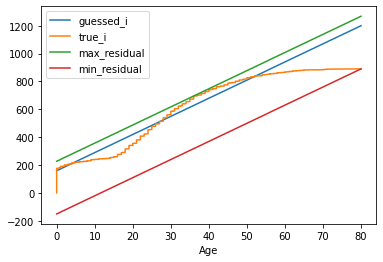

In [348]:
all[['Age', 'guessed_i', 'true_i', 'max_residual', 'min_residual']].plot(x='Age')